In [181]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from pylab import rcParams
%matplotlib inline

In [182]:
df = pd.read_csv('log2.csv')

In [183]:
df["duration_sec"] = df["duration_ns"] / 1000000000
del df["duration_ns"]
del df["instance"]

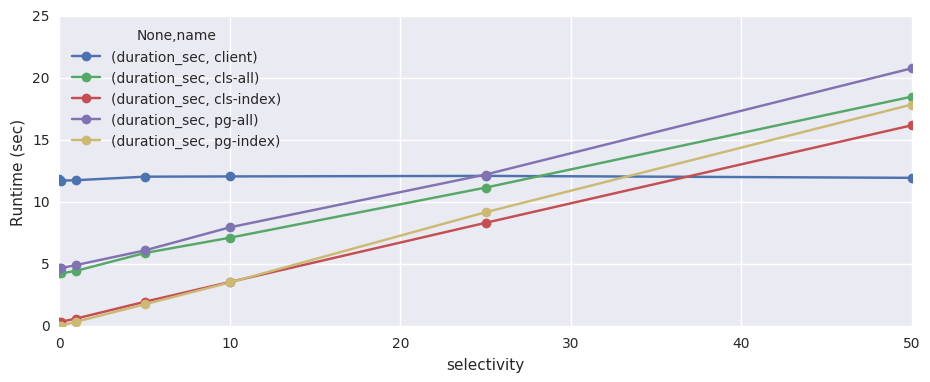

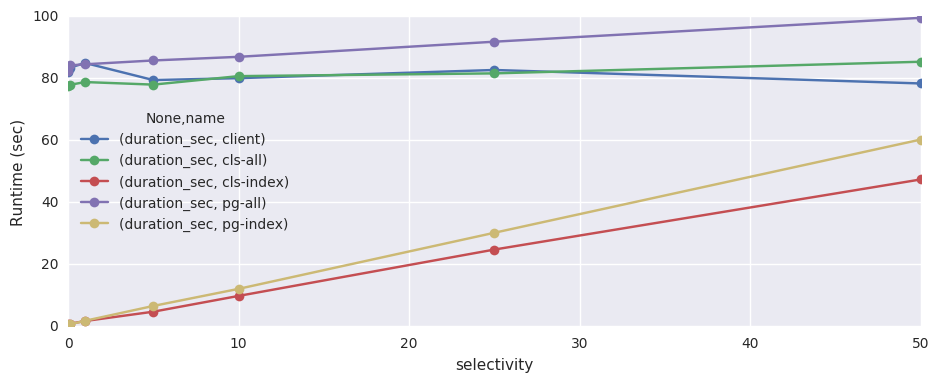

In [187]:
rcParams['figure.figsize'] = 11, 4
df2 = df.groupby(["name", "selectivity", "hotcache"]).mean()
#df2.unstack(level=[2, 0]).swaplevel(axis=1)
df3 = df2.reset_index()
ax = df3[df3.hotcache == True][["name", "selectivity", "duration_sec"]].groupby(["name", "selectivity"]).mean().unstack(level=0).plot(marker='o')
ax.set_ylabel("Runtime (sec)")
ax = df3[df3.hotcache == False][["name", "selectivity", "duration_sec"]].groupby(["name", "selectivity"]).mean().unstack(level=0).plot(marker='o')
ax.set_ylabel("Runtime (sec)")